In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [31]:
df = pd.read_csv('../input/hourly-energy-consumption/DAYTON_hourly.csv')

df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)




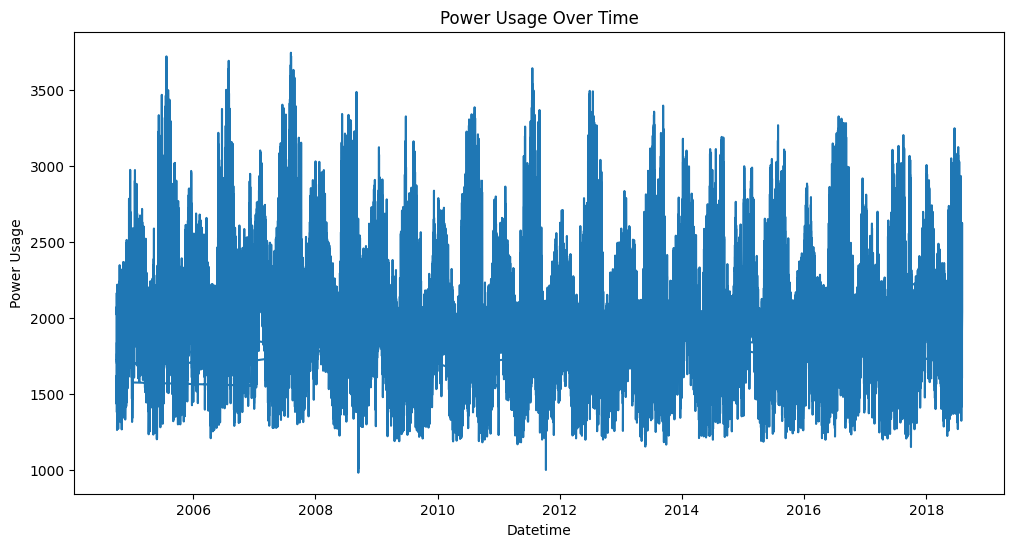

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(df)
plt.title('Power Usage Over Time')
plt.xlabel('Datetime')
plt.ylabel('Power Usage')
plt.show()

In [33]:
print(df.describe())

           DAYTON_MW
count  121275.000000
mean     2037.851140
std       393.403153
min       982.000000
25%      1749.000000
50%      2009.000000
75%      2279.000000
max      3746.000000


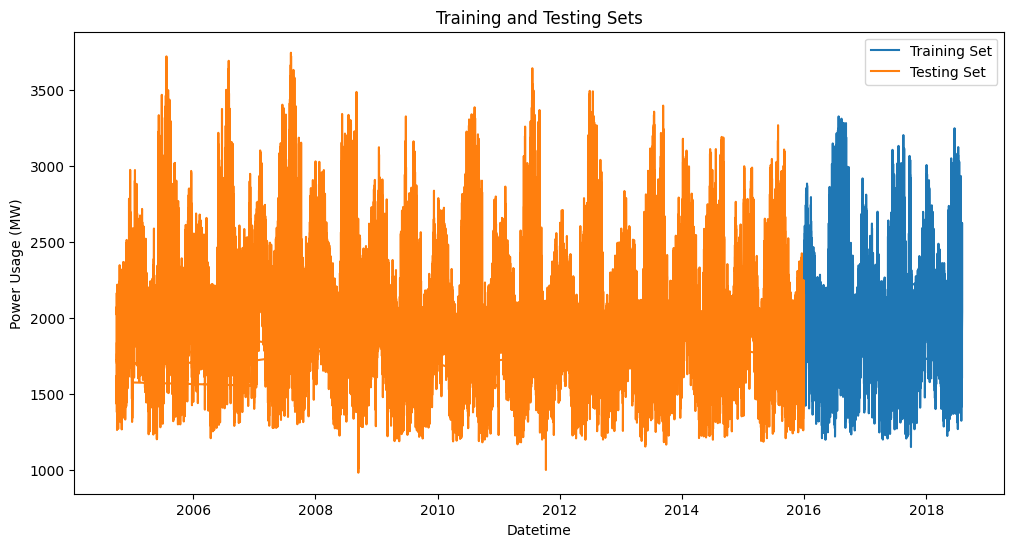

In [34]:
test = df.loc[df.index < '01-01-2016']
train = df.loc[df.index > '01-01-2016']



plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Set')
plt.plot(test.index, test, label='Testing Set')
plt.title('Training and Testing Sets')
plt.xlabel('Datetime')
plt.ylabel('Power Usage (MW)')
plt.legend()
plt.show()

In [35]:
#Creating Features

def creatingfeatures(df):
    
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = creatingfeatures(df)

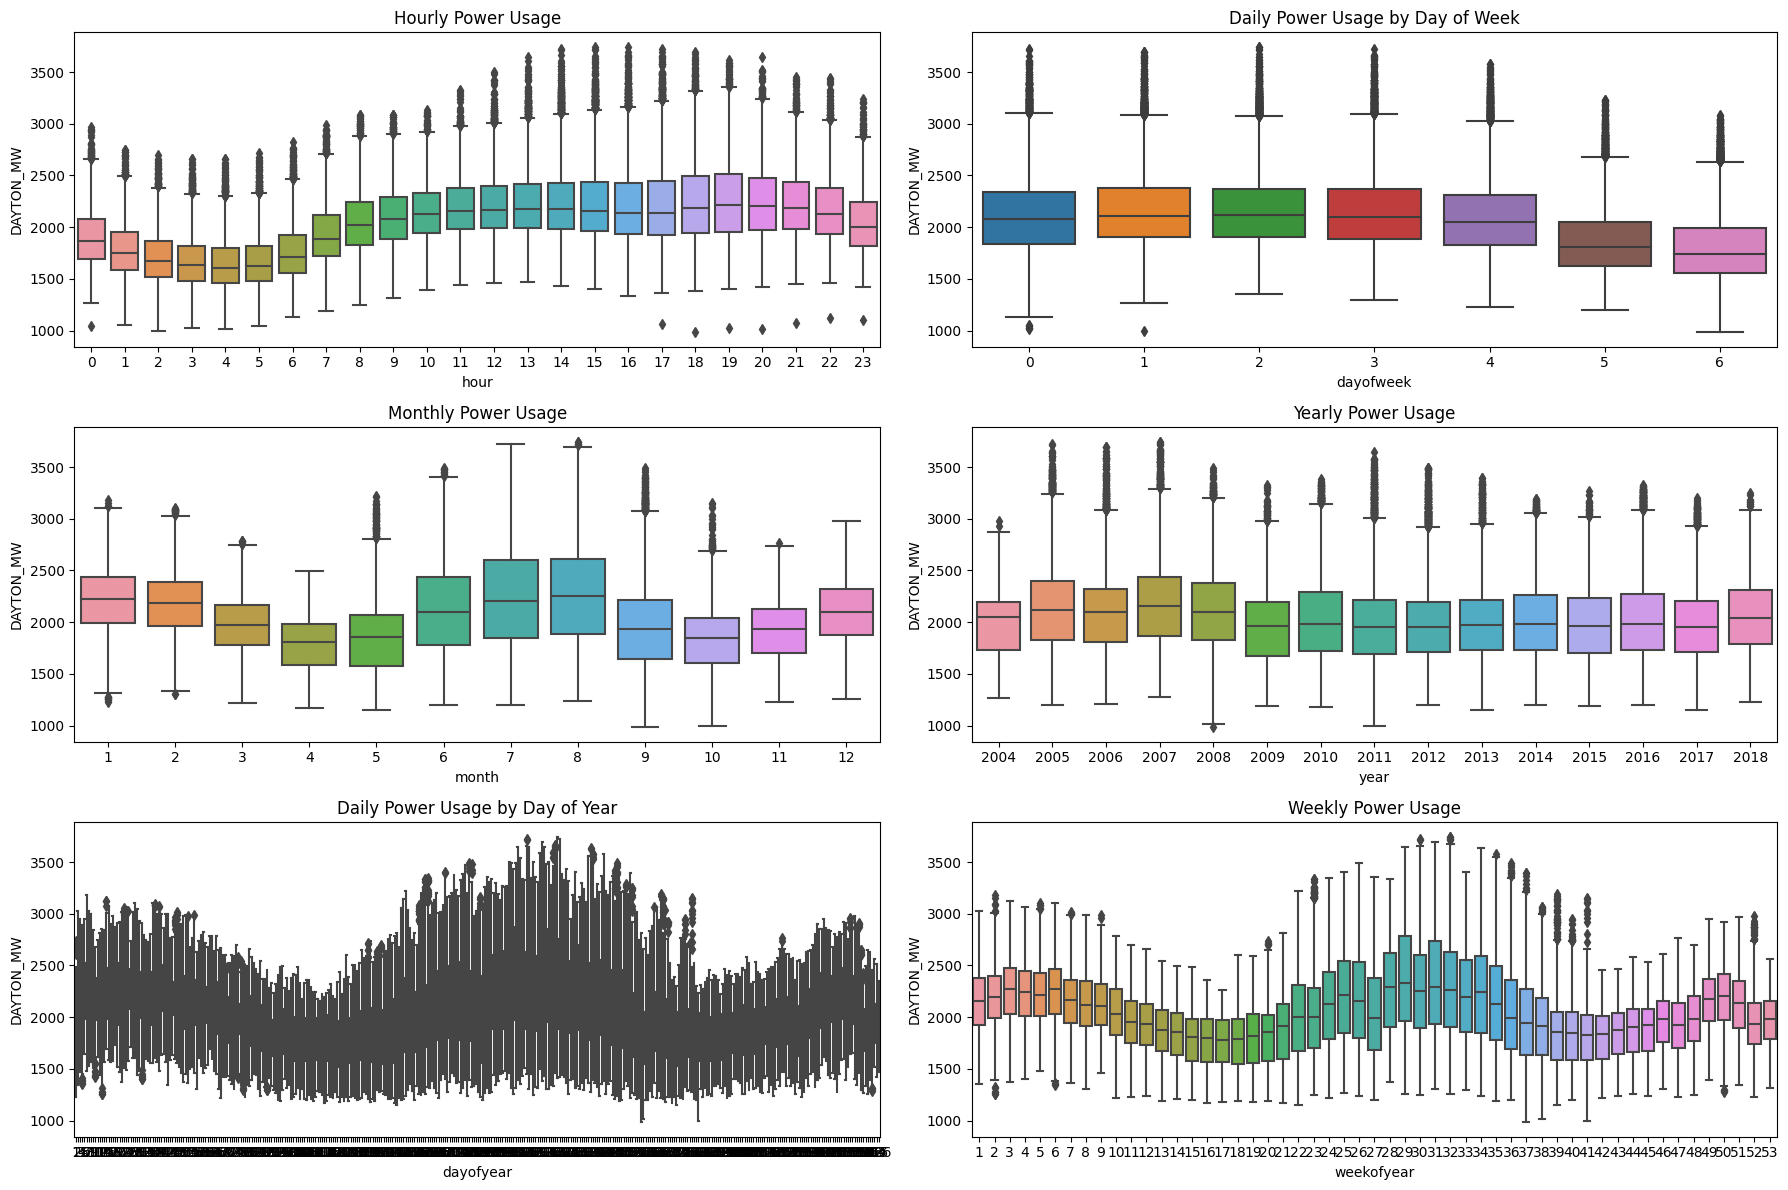

In [36]:
plt.figure(figsize=(18, 12))

# Hourly usage
plt.subplot(3, 2, 1)
sns.boxplot(x='hour', y='DAYTON_MW', data=df)
plt.title('Hourly Power Usage')

# Daily usage by day of week
plt.subplot(3, 2, 2)
sns.boxplot(x='dayofweek', y='DAYTON_MW', data=df)
plt.title('Daily Power Usage by Day of Week')

# Monthly usage
plt.subplot(3, 2, 3)
sns.boxplot(x='month', y='DAYTON_MW', data=df)
plt.title('Monthly Power Usage')

# Yearly usage
plt.subplot(3, 2, 4)
sns.boxplot(x='year', y='DAYTON_MW', data=df)
plt.title('Yearly Power Usage')

# Daily usage by day of year
plt.subplot(3, 2, 5)
sns.boxplot(x='dayofyear', y='DAYTON_MW', data=df)
plt.title('Daily Power Usage by Day of Year')

# Weekly usage
plt.subplot(3, 2, 6)
sns.boxplot(x='weekofyear', y='DAYTON_MW', data=df)
plt.title('Weekly Power Usage')

plt.tight_layout()
plt.show()

In [37]:
train = creatingfeatures(train)

test = creatingfeatures(test)
features = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
target = 'DAYTON_MW'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [46]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform


param_dist = {
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 20),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 0.5),
    'reg_lambda': uniform(0, 0.5),
}


reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)


random_search = RandomizedSearchCV(estimator=reg, param_distributions=param_dist, n_iter=50, scoring='neg_mean_squared_error', cv=3, verbose=2, random_state=42)

# Perform random search
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_

# Train the model with the best parameters
best_reg = random_search.best_estimator_
best_reg.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=0.6872700594236812, gamma=0.4753571532049581, learning_rate=0.15639878836228102, max_depth=7, min_child_weight=7, reg_alpha=0.22291637642679557, reg_lambda=0.04998745790900144, subsample=0.7296244459829335; total time=   8.5s
[CV] END colsample_bytree=0.6872700594236812, gamma=0.4753571532049581, learning_rate=0.15639878836228102, max_depth=7, min_child_weight=7, reg_alpha=0.22291637642679557, reg_lambda=0.04998745790900144, subsample=0.7296244459829335; total time=   1.8s
[CV] END colsample_bytree=0.6872700594236812, gamma=0.4753571532049581, learning_rate=0.15639878836228102, max_depth=7, min_child_weight=7, reg_alpha=0.22291637642679557, reg_lambda=0.04998745790900144, subsample=0.7296244459829335; total time=   1.8s
[CV] END colsample_bytree=0.6668543055695109, gamma=0.07143340896097039, learning_rate=0.14017769458977059, max_depth=7, min_child_weight=2, reg_alpha=0.36099938613341237, reg_lambda

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6779863393256308, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.37892305523218456,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.012878697725951174,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

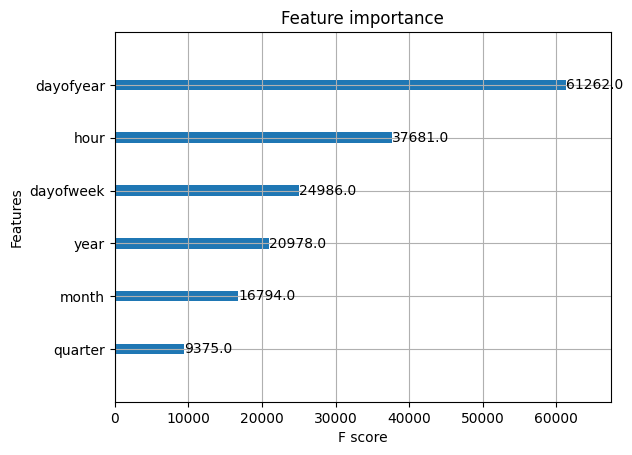

In [47]:
xgb.plot_importance(best_reg, importance_type='weight', max_num_features=10)  # Adjust max_num_features as needed
plt.show()

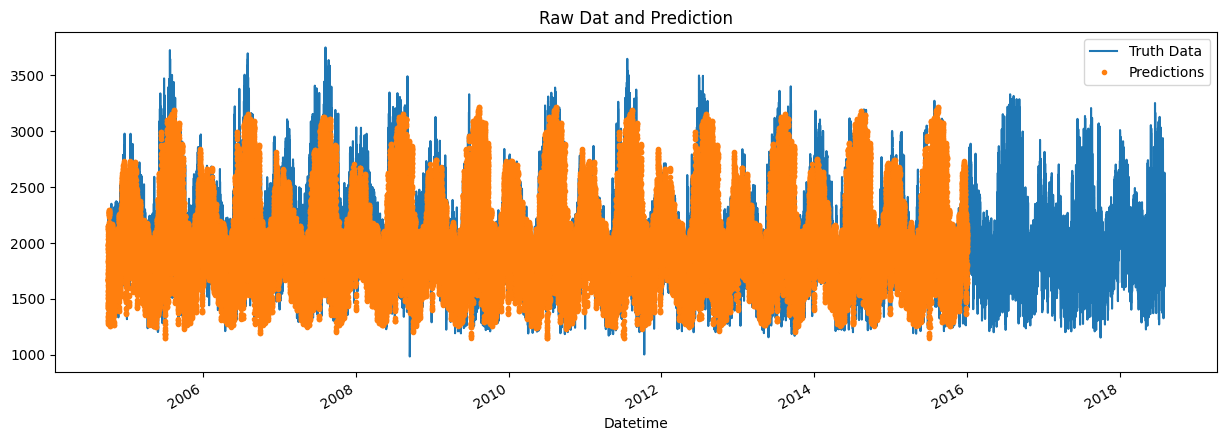

In [50]:
test['prediction'] = best_reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['DAYTON_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [53]:
score = np.sqrt(mean_squared_error(test['DAYTON_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 248.06
